# Loading some packages

In [25]:
import pandas as pd
import numpy as np

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold, RandomizedSearchCV
from sklearn.linear_model import Lasso, Ridge
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.feature_selection import RFE
from sklearn.feature_selection import r_regression, SelectKBest
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

from xgboost import XGBRegressor

from lightgbm import LGBMRegressor

from scipy import stats

from statsmodels.stats.outliers_influence import variance_inflation_factor

from boruta import BorutaPy

from BorutaShap import BorutaShap

from collections import Counter

import shap

import os
from pathlib import Path

import warnings 
warnings.filterwarnings('ignore')

In [2]:
import boruta

boruta.__file__

'c:\\Users\\vchar\\anaconda3\\envs\\ml_projects\\lib\\site-packages\\boruta\\__init__.py'

# Loading the data

In [44]:
DATA_PATH = Path(r'C:/\Users/\vchar/\OneDrive/\Desktop/\ML Projects/\portfolio/\ArmenianHousePrices/\notebooks/\data')

data = pd.read_csv(os.path.join(DATA_PATH, 'final_data.csv'))

cat_feats_list = list(data.select_dtypes(include=['object']).columns)
remove_cat_list =[
    'description', 'address', 'seller_type', 'total_description',
    'renewed_date', 'seller_id', 'region', 'geo_location', 'estate_type'
]
cat_feats_list = [i for i in cat_feats_list if i not in remove_cat_list]
cat_feats_list = ['Number of Rooms',
 'Renovation',
 'Furniture',
 'New Construction',
 'Construction Type',
 'Number of Bathrooms',
 'Balcony',
 'Elevator']
print(cat_feats_list)

ordinal_feats_list = ['Number of Rooms', 'Number of Bathrooms']

nominal_feats_list = [i for i in cat_feats_list if i not in ordinal_feats_list]

num_feats_list = list(data.select_dtypes(exclude=['object']).columns)
remove_num_feats_list = ['posted_date', 'sqm_price_usd', 'estate_id', 'latitude', 'longitude', 'geo_location']
remove_ordinal_feats_list = [
    'Floor', 'Floors in the Building'
]
ordinal_feats_list.extend(remove_ordinal_feats_list)
cat_feats_list.extend(remove_ordinal_feats_list)
remove_nominal_feats_list = [
    'covered parking', 'outdoor parking', 'garage', 'air conditioner', 'dishwasher',
    'washing machine', 'fridge', 'drying machine', 'stove', 'park view', 'street view', 
    'view of Ararat', 'yard view', 'city view', 'concierge', 'intercom entry', 
    'playground', 'is_capital'
]
nominal_feats_list.extend(remove_nominal_feats_list)
cat_feats_list.extend(remove_nominal_feats_list)
num_feats_list = [i for i in num_feats_list if i not in remove_num_feats_list and i not in cat_feats_list]
num_feats_list = [i for i in num_feats_list if i not in remove_ordinal_feats_list and i not in remove_nominal_feats_list]
# feats_name_list = [col for col in data.columns if col!='']
print(num_feats_list)

feats_name_list = []
feats_name_list.extend(cat_feats_list)
feats_name_list.extend(num_feats_list)

data = data[data['is_capital']==1]
data.reset_index(drop=True, inplace=True)
data.drop(columns='is_capital', inplace=True)
cat_feats_list.remove('is_capital')
feats_name_list.remove('is_capital')
nominal_feats_list.remove('is_capital')

y = data['sqm_price_usd'].copy().to_frame()
X = data[feats_name_list].copy()

['Number of Rooms', 'Renovation', 'Furniture', 'New Construction', 'Construction Type', 'Number of Bathrooms', 'Balcony', 'Elevator']
['Ceiling Height', 'Floor Area', 'city_attr_0', 'city_attr_1', 'city_attr_2', 'city_attr_3', 'city_attr_4', 'city_attr_5', 'city_attr_6', 'city_attr_7', 'city_attr_8', 'city_attr_9', 'city_attr_10', 'city_attr_11', 'metro_station_0', 'metro_station_1', 'metro_station_2', 'metro_station_3', 'metro_station_4', 'metro_station_5', 'metro_station_6', 'metro_station_7', 'metro_station_8', 'metro_station_9', 'closest_metro_distance', 'mall_0', 'mall_1', 'mall_2', 'mall_3', 'closest_mall_distance']


In [45]:
X.head()

,Number of Rooms,Renovation,Furniture,New Construction,Construction Type,Number of Bathrooms,Balcony,Elevator,Floor,Floors in the Building,...,metro_station_6,metro_station_7,metro_station_8,metro_station_9,closest_metro_distance,mall_0,mall_1,mall_2,mall_3,closest_mall_distance
0,2,0,0,0,0,1,0,0,3,9,...,61.169827,53.006584,29.637074,244.102697,24.408433,186.156946,129.294787,124.079898,293.619775,124.079898
1,3,1,0,0,0,1,1,0,14,16,...,139.532072,103.661085,49.488490,196.393410,22.690618,134.940334,208.131945,157.861426,300.968318,134.940334
2,2,2,1,0,1,1,1,1,4,5,...,273.024165,324.852997,275.092613,183.363983,145.966273,198.004532,311.409442,154.460103,565.084056,154.460103
3,3,3,2,0,0,1,2,1,1,5,...,334.600766,265.608187,313.773654,514.741262,265.608187,454.336069,344.228264,440.023840,23.111663,23.111663
4,3,4,0,0,0,1,0,0,4,10,...,131.678114,83.056489,42.581168,222.421567,42.581168,160.966858,197.407935,170.063984,275.782140,160.966858


# Feature elimination

## Removing low variance features

In [5]:
variance_selector = VarianceThreshold(threshold=0.05)
variance_selector.fit(X[num_feats_list])
# X_selection = variance_selector.fit_transform(X[num_feats_list])
var_selected_feats = X[num_feats_list].iloc[:, list(variance_selector.get_support())].columns.to_list()
print('Numeric features to remove:')
[col for col in num_feats_list if col not in var_selected_feats]

Numeric features to remove:


['Ceiling Height', 'covered parking', 'garage', 'drying machine']

In [6]:
X['Ceiling Height'].value_counts()

Ceiling Height
3.00    6838
2.75    6040
2.80    4692
2.70    2315
3.20    1234
2.60     512
3.50     332
2.50     194
Name: count, dtype: int64

In [7]:
len(num_feats_list)

50

In [13]:
X_selection.shape

(22157, 56)

## Variance Inflation Factor

In [ ]:
def calculate_vif(X):
    
    vif = pd.DataFrame()
    vif["features"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

    return vif

def select_feats_via_vif(X):

    vif_df = calculate_vif(X)

    while vif_df[vif_df['VIF'] >=10].shape[0] != 0:
        vif_df.sort_values('VIF', ascending=False).reset_index(drop=True, inplace=True)
        elimination_candidate = vif_df.iloc[0]['features']
        new_X = X.drop(columns=elimination_candidate)
        vif_df = calculate_vif(new_X)

    return list(vif_df['features'].values)

In [ ]:
# knn = KNeighborsClassifier(n_neighbors=3)
# sfs = SequentialFeatureSelector(knn, n_features_to_select=3, direction=”forward”)
# sfs.fit(X, y)
# X_selection = sfs.transform(X)

# svc = SVC(kernel="linear")
# rfe = RFE(svc, n_features_to_select=3)
# rfe.fit(X, y)
# X_selection = rfe.transform(X)

## Feature selection class

In [21]:
selector = SelectKBest(r_regression, k=15)
selector.fit_transform(X[num_feats_list], y)
selected_feats_idxs_list = list(selector.get_support(indices=True))
column_names = [num_feats_list[i] for i in selected_feats_idxs_list]
column_names

c:\Users\vchar\anaconda3\envs\ml_projects\lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


['Ceiling Height',
 'Floor',
 'New Construction',
 'Construction Type',
 'Number of Bathrooms',
 'Floors in the Building',
 'air conditioner',
 'dishwasher',
 'washing machine',
 'fridge',
 'drying machine',
 'stove',
 'concierge',
 'intercom entry',
 'is_capital']

In [30]:
class FSelector():

    def __init__(self, X, y, num_feats, ordinal_feats, nominal_feats, model):

        self.X = X
        self.y = y
        self.num_feats = num_feats
        self.ordinal_feats = ordinal_feats
        self.nominal_feats = nominal_feats
        self.model = model

    def calculate_vif(self, X):
    
        vif = pd.DataFrame()
        vif["features"] = X.columns
        vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

        return vif

    def select_feats_via_vif(self):

        num_features = self.num_feats.copy()

        vif_df = self.calculate_vif(self.X[num_features])

        while vif_df[vif_df['VIF']>=10].shape[0] != 0:
            vif_df.sort_values('VIF', ascending=False, inplace=True)
            vif_df.reset_index(drop=True, inplace=True)
            # print(vif_df)
            elimination_candidate = vif_df.iloc[0]['features']
            # print(elimination_candidate)
            num_features = [i for i in num_features if i!=elimination_candidate]
            new_X = self.X[num_features]
            vif_df = self.calculate_vif(new_X)

        return list(vif_df['features'].values)
    
    def get_spearmanr(self, X, y):
        # return np.array([stats.spearmanr(X.values[:, f], y.values).correlation for f in range(X.shape[1])])
        spearman_values = [stats.spearmanr(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
        temp_sp_df = pd.DataFrame({'spearman': spearman_values, 'feats': list(X.columns)})
        temp_sp_df['abs_spearman'] = np.abs(temp_sp_df['spearman'])
        temp_sp_df.sort_values('abs_spearman', ascending=False, inplace=True)
        temp_sp_df.reset_index(drop=True, inplace=True)
        return temp_sp_df.iloc[:15]['feats'].to_list()
    
    def get_kendalltau(self, X, y):
        # return [stats.kendalltau(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
        kendall_values = [stats.spearmanr(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
        temp_ken_df = pd.DataFrame({'kendall': kendall_values, 'feats': list(X.columns)})
        temp_ken_df['abs_kendall'] = np.abs(temp_ken_df['kendall'])
        temp_ken_df.sort_values('abs_kendall', ascending=False, inplace=True)
        temp_ken_df.reset_index(drop=True, inplace=True)
        return temp_ken_df.iloc[:15]['feats'].to_list()
    
    def get_pointbiserialr(self, X, y):
        return [stats.pointbiserialr(X.values[:, f], y.values).correlation for f in range(X.shape[1])]
    
    def get_boruto_feats(self):
        feat_selector = BorutaPy(self.model, n_estimators='auto', verbose=2, random_state=1)
        feat_selector.fit(np.array(self.X), np.array(self.y))
        return feat_selector.support_
    
    def get_kbest(self, X, feats_list, metric, k=15):
        selector = SelectKBest(metric, k=k)
        selector.fit_transform(X[feats_list], self.y)
        selected_feats_idxs_list = list(selector.get_support(indices=True))
        column_names = [num_feats_list[i] for i in selected_feats_idxs_list]
        return column_names
    
    def get_votes(self):

        if self.num_feats is not None:

            self.vif_feats = self.select_feats_via_vif()

            self.pearson_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=r_regression, k=15)
            # self.num_spearmanr_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=stats.spearmanr, k=15)
            # self.num_kendalltau_feats = self.get_kbest(X=self.X, feats_list=self.num_feats, metric=stats.kendalltau, k=15)
            self.num_spearmanr_feats = self.get_spearmanr(self.X[self.num_feats], self.y)
            self.num_kendalltau_feats = self.get_kendalltau(self.X[self.num_feats], self.y)
            # self.num_spearmanr_feats = SelectKBest(self.get_spearmanr, k=15).fit_transform(self.X[self.num_feats], self.y)
            # self.num_kendalltau_feats = SelectKBest(self.get_kendalltau, k=15).fit_transform(self.X[self.num_feats], self.y)

            self.selected_num_feats = []
            self.selected_num_feats.extend(self.pearson_feats)
            self.selected_num_feats.extend(self.num_spearmanr_feats)
            self.selected_num_feats.extend(self.num_kendalltau_feats)
            # self.selected_num_feats = list(set(self.selected_num_feats))

        if self.ordinal_feats is not None:

            self.ordinal_spearmanr_feats = self.get_spearmanr(self.X[self.ordinal_feats], self.y)
            self.ordinal_kendalltau_feats = self.get_kendalltau(self.X[self.ordinal_feats], self.y)

            # self.ordinal_spearmanr_feats = self.get_kbest(X=self.X, feats_list=self.ordinal_feats, metric=stats.spearmanr, k=15)
            # self.ordinal_kendalltau_feats = self.get_kbest(X=self.X, feats_list=self.ordinal_feats, metric=stats.kendalltau, k=15)

            # self.ordinal_spearmanr_feats = SelectKBest(self.get_spearmanr, k=15).fit_transform(self.X[self.ordinal_feats], self.y)
            # self.ordinal_kendalltau_feats = SelectKBest(self.get_kendalltau, k=15).fit_transform(self.X[self.ordinal_feats], self.y)

            self.selected_ordinal_feats = []
            self.selected_ordinal_feats.extend(self.ordinal_spearmanr_feats)
            self.selected_ordinal_feats.extend(self.ordinal_kendalltau_feats)
            # self.selected_ordinal_feats = list(set(self.selected_ordinal_feats))

        if self.nominal_feats is not None:

            self.f_feats = self.get_kbest(X=self.X, feats_list=self.nominal_feats, metric=f_classif, k=15)
            self.mi_feats = self.get_kbest(X=self.X, feats_list=self.nominal_feats, metric=mutual_info_regression, k=15)

            # # self.f_feats = f_classif(self.X[self.nominal_feats], self.y)[0]
            # self.f_feats = SelectKBest(f_classif, k=15).fit_transform(self.X[self.nominal_feats], self.y).columns
            
            # # self.mi_feats = mutual_info_regression(self.X[self.nominal_feats], self.y)
            # self.mi_feats = SelectKBest(mutual_info_regression, k=15).fit_transform(self.X[self.nominal_feats], self.y).columns

            self.selected_nominal_feats = []
            self.selected_nominal_feats.extend(self.f_feats)
            self.selected_nominal_feats.extend(self.mi_feats)
            # self.selected_nominal_feats = list(set(self.selected_nominal_feats))

        if self.model is not None:
            # np.int = np.int32
            # np.float = np.float64
            # np.bool = np.bool_
            self.boruto_feats =  self.get_boruto_feats(self.model)

        # self.selected_num_feats.extend(self.boruto_feats)
        num_feats_dict = dict(Counter(self.selected_num_feats))
        self.selected_num_feats = [i for i in num_feats_dict if num_feats_dict[i] > 2]

        # self.selected_ordinal_feats.extend(self.boruto_feats)
        ordinal_feats_dict = dict(Counter(self.selected_ordinal_feats))
        self.selected_ordinal_feats = [i for i in ordinal_feats_dict if ordinal_feats_dict[i] >= 2]

        # self.selected_nominal_feats.extend(self.boruto_feats)
        nominal_feats_dict = dict(Counter(self.selected_nominal_feats))
        self.selected_nominal_feats = [i for i in nominal_feats_dict if nominal_feats_dict[i] >= 2]

        self.selected_feats = []
        self.selected_feats.extend(self.selected_num_feats)
        self.selected_feats.extend(self.selected_ordinal_feats)
        self.selected_feats.extend(self.selected_nominal_feats)
        # self.selected_feats.extend(self.boruto_feats)
        self.selected_feats = list(set(self.selected_feats))

        return self.selected_feats

In [9]:
fselector = FSelector(
    X=X, 
    y=y, 
    num_feats=num_feats_list, 
    ordinal_feats=ordinal_feats_list, 
    nominal_feats=nominal_feats_list, 
    model=RandomForestRegressor()
)

# fselector.select_feats_via_vif()

fselector.get_boruto_feats()

In [46]:
models_list = [RandomForestRegressor(), XGBRegressor(), LGBMRegressor()]
model_names_list = ['RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor']
feats_dict = {}

for i in range(len(models_list)):

    model = models_list[i]
    
    fselector = FSelector(
        X=X, 
        y=y, 
        num_feats=num_feats_list, 
        ordinal_feats=ordinal_feats_list, 
        nominal_feats=nominal_feats_list, 
        model=None
    )

    selected_feats_list = fselector.get_votes()

    feats_dict[model_names_list[i]] = selected_feats_list

    print(f"{model_names_list[i]}: {selected_feats_list}")

RandomForestRegressor: ['metro_station_3', 'city_attr_3', 'city_attr_10', 'Floor', 'Floors in the Building', 'mall_2', 'Number of Rooms', 'Ceiling Height', 'city_attr_7', 'metro_station_0', 'Number of Bathrooms', 'city_attr_8', 'city_attr_6', 'city_attr_1', 'city_attr_2', 'metro_station_6', 'Floor Area', 'city_attr_0', 'metro_station_5']
XGBRegressor: ['city_attr_3', 'city_attr_10', 'Floor', 'Floors in the Building', 'mall_2', 'Number of Rooms', 'Ceiling Height', 'city_attr_7', 'metro_station_0', 'Number of Bathrooms', 'city_attr_8', 'city_attr_6', 'city_attr_1', 'city_attr_11', 'city_attr_2', 'metro_station_6', 'Floor Area', 'city_attr_0', 'metro_station_5']
LGBMRegressor: ['Floors in the Building', 'city_attr_7', 'metro_station_0', 'mall_2', 'Number of Bathrooms', 'Number of Rooms', 'city_attr_2', 'city_attr_3', 'city_attr_8', 'city_attr_10', 'city_attr_6', 'metro_station_6', 'Floor Area', 'city_attr_0', 'city_attr_1', 'metro_station_5', 'Ceiling Height', 'Floor']


In [32]:
models_list = [RandomForestRegressor(), XGBRegressor(), LGBMRegressor()]
model_names_list = ['RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor']

for i in range(len(models_list)):

    model = models_list[i]

    X_train = X[feats_dict[model_names_list[i]]]

    model.fit(X_train, y)

    y_pred = model.predict(X_train)

    temp_mse = mean_squared_error(y, y_pred)

    print(f"{model_names_list[i]}: {temp_mse}")

RandomForestRegressor: 89270.49470584012
XGBRegressor: 382363.4585991109
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000593 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3119
[LightGBM] [Info] Number of data points in the train set: 22157, number of used features: 17
[LightGBM] [Info] Start training from score 2044.252074
LGBMRegressor: 524812.5583874322


In [20]:
# spearman_values = fselector.get_spearmanr(X[num_feats_list], y)
# temp_sp_df = pd.DataFrame({'spearman': spearman_values, 'feats': num_feats_list})
# temp_sp_df['abs_spearman'] = np.abs(temp_sp_df['spearman'])
# temp_sp_df.sort_values('abs_spearman', ascending=False, inplace=True)
# temp_sp_df.reset_index(drop=True, inplace=True)
# temp_sp_df.iloc[:15]['feats'].to_list()

['Ceiling Height',
 'is_capital',
 'air conditioner',
 'concierge',
 'intercom entry',
 'dishwasher',
 'Floors in the Building',
 'fridge',
 'washing machine',
 'stove',
 'drying machine',
 'covered parking',
 'Floor',
 'city view',
 'yard view']

In [28]:
rf = RandomForestRegressor()
rf_rfe = RFE(rf, n_features_to_select=15)
rf_rfe.fit(X, y)
# X_selection = rf_rfe.transform(X)
rf_rfe_feats = X.iloc[:, list(rf_rfe.support_)].columns
rf_rfe_feats

RFE(estimator=RandomForestRegressor(), n_features_to_select=15)

In [29]:
rf_rfe_feats = X.iloc[:, list(rf_rfe.support_)].columns
rf_rfe_feats

Index(['Renovation', 'Construction Type', 'Ceiling Height', 'Floor',
       'Floor Area', 'Floors in the Building', 'is_capital', 'city_attr_4',
       'city_attr_8', 'city_attr_10', 'metro_station_3', 'mall_1', 'mall_2',
       'mall_3', 'closest_mall_distance'],
      dtype='object')

In [30]:
xgbr = XGBRegressor()
xgb_rfe = RFE(xgbr, n_features_to_select=15)
xgb_rfe.fit(X, y)
# X_selection = xgb_rfe.transform(X)
xgb_rfe_feats = X.iloc[:, list(xgb_rfe.support_)].columns
xgb_rfe_feats

RFE(estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                           colsample_bylevel=None, colsample_bynode=None,
                           colsample_bytree=None, device=None,
                           early_stopping_rounds=None, enable_categorical=False,
                           eval_metric=None, feature_types=None, gamma=None,
                           grow_policy=None, importance_type=None,
                           interaction_constraints=None, learning_rate=None,
                           max_bin=None, max_cat_threshold=None,
                           max_cat_to_onehot=None, max_delta_step=None,
                           max_depth=None, max_leaves=None,
                           min_child_weight=None, missing=nan,
                           monotone_constraints=None, multi_strategy=None,
                           n_estimators=None, n_jobs=None,
                           num_parallel_tree=None, random_state=None, ...),
    n_features_to_select=15)

In [31]:
xgb_rfe_feats = X.iloc[:, list(xgb_rfe.support_)].columns
xgb_rfe_feats

Index(['Renovation', 'Furniture', 'New Construction', 'Construction Type',
       'Number of Bathrooms', 'Elevator', 'Ceiling Height', 'Floor Area',
       'Floors in the Building', 'air conditioner', 'view of Ararat',
       'concierge', 'intercom entry', 'playground', 'is_capital'],
      dtype='object')

In [32]:
lgbmr = LGBMRegressor()
lgbmr_rfe = RFE(lgbmr, n_features_to_select=15)
lgbmr_rfe.fit(X, y)
# X_selection = lgbmr_rfe.transform(X)
lgbmr_rfe_feats = X.iloc[:, list(lgbmr_rfe.support_)].columns
lgbmr_rfe_feats

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7514
[LightGBM] [Info] Number of data points in the train set: 22157, number of used features: 58
[LightGBM] [Info] Start training from score 2044.252074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012610 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7259
[LightGBM] [Info] Number of data points in the train set: 22157, number of used features: 57
[LightGBM] [Info] Start training from score 2044.252074
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014107 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7004
[LightGBM] [Info] Number of data points in the train set: 22157, number of used features: 56
[LightGBM] [Info] Sta

RFE(estimator=LGBMRegressor(), n_features_to_select=15)

In [33]:
lgbmr_rfe_feats = X.iloc[:, list(lgbmr_rfe.support_)].columns
lgbmr_rfe_feats

Index(['Number of Rooms', 'Renovation', 'New Construction',
       'Construction Type', 'Balcony', 'Ceiling Height', 'Floor', 'Floor Area',
       'Floors in the Building', 'city_attr_4', 'city_attr_11',
       'metro_station_3', 'closest_metro_distance', 'mall_3',
       'closest_mall_distance'],
      dtype='object')

In [84]:
selector = BorutaShap(importance_measure='shap', classification=False)
selector.fit(X=X, y=y, n_trials=1, sample=False, verbose=True)

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
features_to_remove = selector.features_to_remove
boruta_shap_selected_feats = [col for col in feats_name_list if col not in features_to_remove]
boruta_shap_selected_feats

## Fold creation

In [47]:
# kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# cv_split_list = []

# for train_idxs, valid_idxs in kfold.split(X):
#     cv_split_list.append((train_idxs, valid_idxs))

kf = KFold(n_splits=10, shuffle=True, random_state=13)
kf_cv_list = [idxs for idxs in kf.split(X)]

In [48]:
models_list = [RandomForestRegressor(), XGBRegressor(), LGBMRegressor()]
model_names_list = ['RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor']

mse_dict = {}

for i in range(len(models_list)):

    temp_mse_list = []

    for fold in range(10):

        model = models_list[i]

        X_train = X.iloc[kf_cv_list[fold][0], :][feats_dict[model_names_list[i]]]
        y_train = y.iloc[kf_cv_list[fold][0], :]

        X_valid = X.iloc[kf_cv_list[fold][1], :][feats_dict[model_names_list[i]]]
        y_valid = y.iloc[kf_cv_list[fold][1], :]

        model.fit(X_train, y_train)

        y_valid_pred = model.predict(X_valid)

        temp_valid_mse = mean_squared_error(y_valid, y_valid_pred)

        temp_mse_list.append(temp_valid_mse)

        # print(f"{model_names_list[i]}: {temp_valid_mse}")

    mse_dict[model_names_list[i]] = temp_mse_list

    print(f"{model_names_list[i]}: {temp_mse_list}")

RandomForestRegressor: [594541.7048903822, 648609.4400514856, 799022.5825634988, 565895.6542146908, 593953.0823258045, 606721.0787322767, 569494.7220023938, 653712.2819070381, 639766.2280833899, 513091.9340719255]
XGBRegressor: [611509.9471851384, 642965.3461187148, 804719.9452877116, 572868.1544852926, 606413.0606420117, 607371.8754333991, 596868.635913156, 681073.6726709458, 640596.6485719063, 533489.1165942848]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000942 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3364
[LightGBM] [Info] Number of data points in the train set: 18728, number of used features: 18
[LightGBM] [Info] Start training from score 2116.671887
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of tes

In [47]:
for i in range(5):
    train_idxs = kf_cv_list[i][0]
    rf = RandomForestRegressor()
    rf_rfe = RFE(rf, n_features_to_select=15)
    rf_rfe.fit(X.iloc[train_idxs, :], y.iloc[train_idxs, :])
    rf_rfe_feats = X.iloc[:, list(rf_rfe.support_)].columns
    print(f"fold {i}: {rf_rfe_feats}")

fold 0: Index(['Renovation', 'Furniture', 'Ceiling Height', 'Floor', 'Floor Area',
       'Floors in the Building', 'is_capital', 'city_attr_4', 'city_attr_8',
       'city_attr_10', 'metro_station_3', 'mall_1', 'mall_2', 'mall_3',
       'closest_mall_distance'],
      dtype='object')
fold 1: Index(['Renovation', 'Construction Type', 'Ceiling Height', 'Floor',
       'Floor Area', 'Floors in the Building', 'is_capital', 'city_attr_4',
       'city_attr_8', 'city_attr_10', 'metro_station_5', 'mall_1', 'mall_2',
       'mall_3', 'closest_mall_distance'],
      dtype='object')
fold 2: Index(['Renovation', 'Furniture', 'Ceiling Height', 'Floor', 'Floor Area',
       'Floors in the Building', 'is_capital', 'city_attr_3', 'city_attr_4',
       'city_attr_8', 'metro_station_3', 'mall_1', 'mall_2', 'mall_3',
       'closest_mall_distance'],
      dtype='object')
fold 3: Index(['Renovation', 'Construction Type', 'Ceiling Height', 'Floor',
       'Floor Area', 'Floors in the Building', 'is_capi

In [48]:
for i in range(5):
    train_idxs = kf_cv_list[i][0]
    xgbr = XGBRegressor()
    xgb_rfe = RFE(xgbr, n_features_to_select=15)
    xgb_rfe.fit(X.iloc[train_idxs, :], y.iloc[train_idxs, :])
    xgb_rfe_feats = X.iloc[:, list(xgb_rfe.support_)].columns
    print(f"fold {i}: {xgb_rfe_feats}")

fold 0: Index(['Renovation', 'Furniture', 'New Construction', 'Construction Type',
       'Number of Bathrooms', 'Elevator', 'Ceiling Height', 'Floor Area',
       'Floors in the Building', 'air conditioner', 'view of Ararat',
       'concierge', 'intercom entry', 'playground', 'is_capital'],
      dtype='object')
fold 1: Index(['Renovation', 'Furniture', 'New Construction', 'Construction Type',
       'Balcony', 'Elevator', 'Ceiling Height', 'Floor', 'Floor Area',
       'Floors in the Building', 'air conditioner', 'concierge',
       'intercom entry', 'playground', 'is_capital'],
      dtype='object')
fold 2: Index(['Renovation', 'Furniture', 'New Construction', 'Construction Type',
       'Number of Bathrooms', 'Elevator', 'Ceiling Height', 'Floor',
       'Floor Area', 'Floors in the Building', 'air conditioner',
       'view of Ararat', 'concierge', 'playground', 'is_capital'],
      dtype='object')
fold 3: Index(['Renovation', 'Furniture', 'New Construction', 'Construction Type',

In [49]:
for i in range(5):
    train_idxs = kf_cv_list[i][0]
    lgbmr = LGBMRegressor()
    lgbmr_rfe = RFE(lgbmr, n_features_to_select=15)
    lgbmr_rfe.fit(X.iloc[train_idxs, :], y.iloc[train_idxs, :])
    lgbmr_rfe_feats = X.iloc[:, list(lgbmr_rfe.support_)].columns
    print(f"fold {i}: {lgbmr_rfe_feats}")

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004165 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7506
[LightGBM] [Info] Number of data points in the train set: 17725, number of used features: 58
[LightGBM] [Info] Start training from score 2049.298339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003093 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7251
[LightGBM] [Info] Number of data points in the train set: 17725, number of used features: 57
[LightGBM] [Info] Start training from score 2049.298339
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004064 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6996
[LightGBM] [Info] Number of data points in the train set: 17725, number of used features: 56
[LightGBM] [Info] Sta

In [36]:
rf_rfecv = RFECV(
    RandomForestRegressor(),
    cv=kf_cv_list
)
rf_rfecv.fit(X, y)

rf_rfecv_feats = X.iloc[:, list(rf_rfecv.support_)].columns
rf_rfecv_feats

In [ ]:
xgb_rfecv = RFECV(
    XGBRegressor(),
    cv=kf_cv_list
)
xgb_rfecv.fit(X, y)

xgb_rfecv_feats = X.iloc[:, list(xgb_rfecv.support_)].columns
xgb_rfecv_feats

In [ ]:
lgbm_rfecv = RFECV(
    LGBMRegressor(),
    cv=kf_cv_list
)
lgbm_rfecv.fit(X, y)

lgbm_rfecv_feats = X.iloc[:, list(lgbm_rfecv.support_)].columns
lgbm_rfecv_feats

# SHAP

In [49]:
shap_rf = RandomForestRegressor()

X_train = X.iloc[kf_cv_list[0][0], :]
y_train = y.iloc[kf_cv_list[0][0], :]

shap_rf.fit(X_train, y_train)

X_valid = X.iloc[kf_cv_list[0][1], :]
y_valid = y.iloc[kf_cv_list[0][1], :]

explainer = shap.Explainer(shap_rf.predict, X_valid)
shap_values = explainer(X_valid)

PermutationExplainer explainer: 2082it [22:42,  1.52it/s]                          


In [55]:
shap_values.values.shape

(4432, 58)

In [15]:
# shap_values = explainer.shap_values(X_valid)
# shap.plots.bar(shap_values.values)

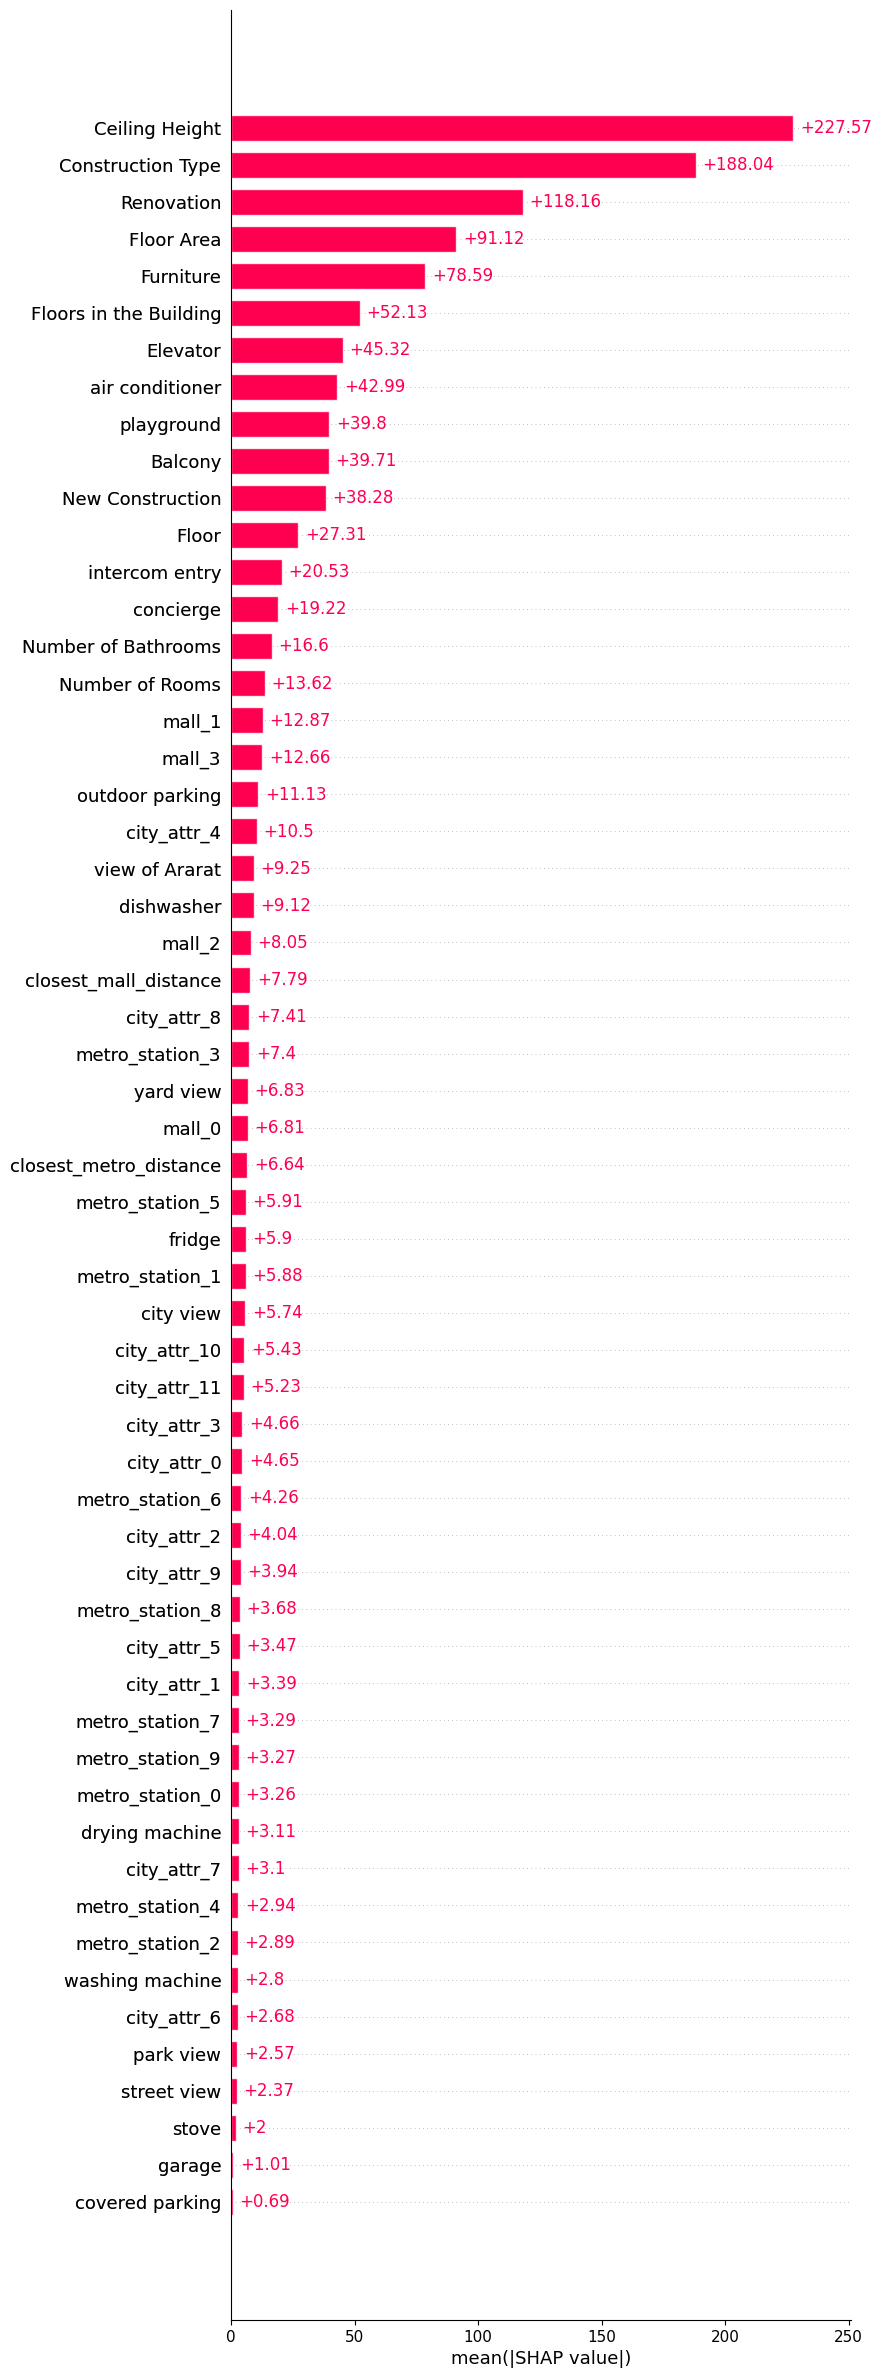

In [50]:
shap.plots.bar(shap_values, max_display=58)

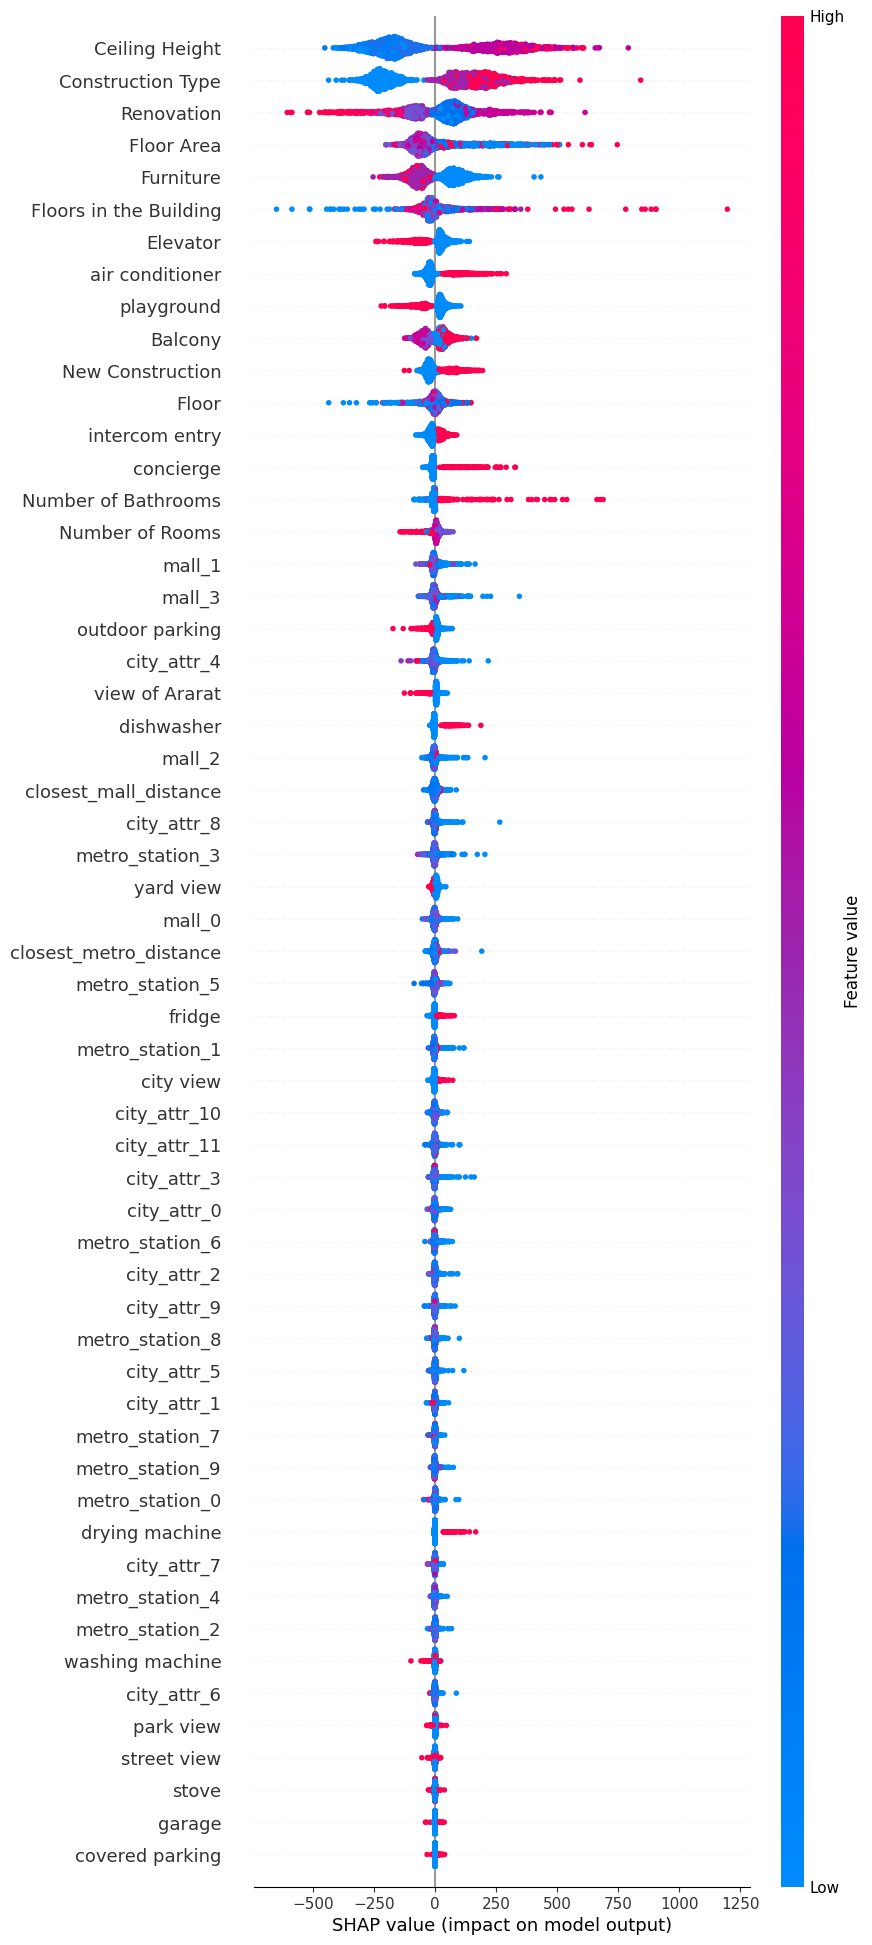

In [51]:
shap.plots.beeswarm(shap_values, max_display=58)

In [52]:
# shap.summary_plot(shap_values)

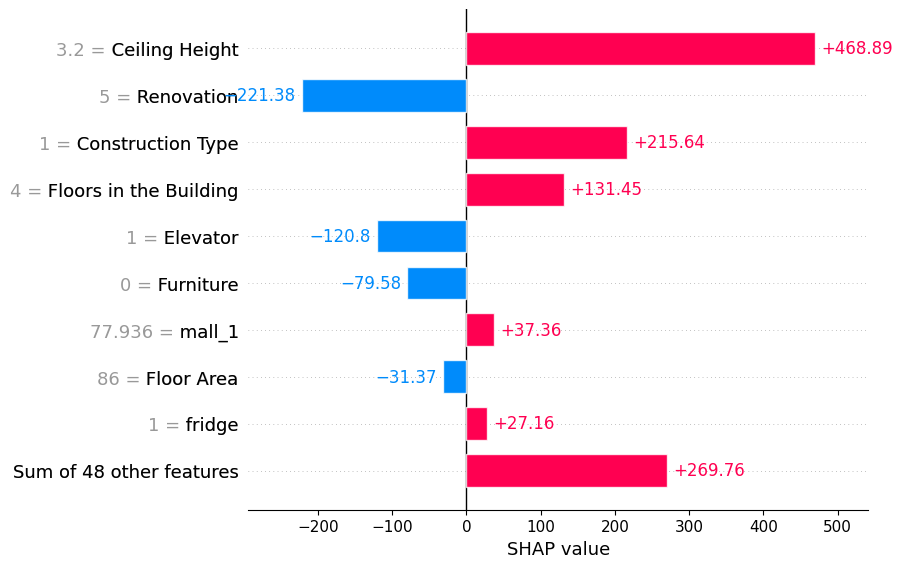

In [53]:
shap.plots.bar(shap_values[0])

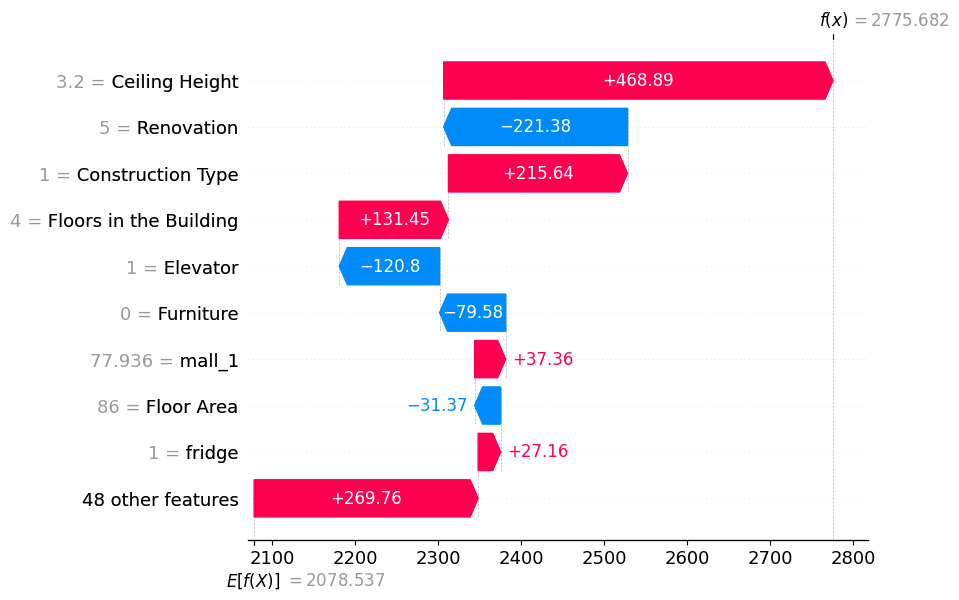

In [54]:
shap.plots.waterfall(shap_values[0])

In [55]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    '''
    Prints the feature importances based on SHAP values in an ordered way
    shap_values -> The SHAP values calculated from a shap.Explainer object
    features -> The name of the features, on the order presented to the explainer
    '''
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
    # Calculates the normalized version
    importances_norm = softmax(importances)
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    # Prints the feature importances
    selected_top10_feats = []
    
    for idx, (k, v) in enumerate(feature_importances.items()):
        print(f"{k} -> {v:.4f} (softmax = {feature_importances_norm[k]:.4f})")
        if idx <=9:
            selected_top10_feats.append(k)

    return selected_top10_feats

In [56]:
selected_shap_features = print_feature_importances_shap_values(shap_values, features=list(X.columns))
selected_shap_features

Ceiling Height -> 227.5734 (softmax = 1.0000)
Construction Type -> 188.0374 (softmax = 0.0000)
Renovation -> 118.1582 (softmax = 0.0000)
Floor Area -> 91.1210 (softmax = 0.0000)
Furniture -> 78.5862 (softmax = 0.0000)
Floors in the Building -> 52.1329 (softmax = 0.0000)
Elevator -> 45.3154 (softmax = 0.0000)
air conditioner -> 42.9868 (softmax = 0.0000)
playground -> 39.7953 (softmax = 0.0000)
Balcony -> 39.7052 (softmax = 0.0000)
New Construction -> 38.2818 (softmax = 0.0000)
Floor -> 27.3129 (softmax = 0.0000)
intercom entry -> 20.5344 (softmax = 0.0000)
concierge -> 19.2249 (softmax = 0.0000)
Number of Bathrooms -> 16.5962 (softmax = 0.0000)
Number of Rooms -> 13.6245 (softmax = 0.0000)
mall_1 -> 12.8675 (softmax = 0.0000)
mall_3 -> 12.6603 (softmax = 0.0000)
outdoor parking -> 11.1263 (softmax = 0.0000)
city_attr_4 -> 10.5009 (softmax = 0.0000)
view of Ararat -> 9.2539 (softmax = 0.0000)
dishwasher -> 9.1207 (softmax = 0.0000)
mall_2 -> 8.0548 (softmax = 0.0000)
closest_mall_distan

['Ceiling Height',
 'Construction Type',
 'Renovation',
 'Floor Area',
 'Furniture',
 'Floors in the Building',
 'Elevator',
 'air conditioner',
 'playground',
 'Balcony']

In [58]:
models_list = [RandomForestRegressor(), XGBRegressor(), LGBMRegressor()]
model_names_list = ['RandomForestRegressor', 'XGBRegressor', 'LGBMRegressor']

shap_mse_dict = {}

for i in range(len(models_list)):

    temp_mse_list = []

    for fold in range(10):

        model = models_list[i]

        X_train = X.iloc[kf_cv_list[fold][0], :][selected_shap_features]
        y_train = y.iloc[kf_cv_list[fold][0], :]

        X_valid = X.iloc[kf_cv_list[fold][1], :][selected_shap_features]
        y_valid = y.iloc[kf_cv_list[fold][1], :]

        model.fit(X_train, y_train)

        y_valid_pred = model.predict(X_valid)

        temp_valid_mse = mean_squared_error(y_valid, y_valid_pred)

        temp_mse_list.append(temp_valid_mse)

        # print(f"{model_names_list[i]}: {temp_valid_mse}")

    shap_mse_dict[model_names_list[i]] = temp_mse_list

    print(f"{model_names_list[i]}: {temp_mse_list}")

RandomForestRegressor: [504687.191330576, 523958.74705939303, 664241.7313547705, 456986.9107303238, 499366.3033871669, 467797.4747947965, 485648.5705994251, 552423.1787524, 506379.704783172, 438565.0598254023]
XGBRegressor: [499521.7372426731, 539478.8988484376, 701151.4659418308, 456903.35435868584, 497359.83333149966, 459362.78574717167, 493307.4981970509, 586966.2343506463, 517834.213771717, 430411.77667868434]
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000592 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 294
[LightGBM] [Info] Number of data points in the train set: 18728, number of used features: 10
[LightGBM] [Info] Start training from score 2116.671887
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [In

# Model construction

## Random Forest

In [42]:
n_estimators_list = [25, 50, 100, 120, 300, 500]#, 800, 1200]

max_depth_list = [5, 8, 15, 25, 30, None]

min_samples_split_list = [2, 5, 10, 15, 100]

min_samples_leaf_list = [2, 5, 10]

max_features_list = ['log2', 'sqrt', None]

params_dict={
    'n_estimators': n_estimators_list,
    'max_depth': max_depth_list,
    'min_samples_split': min_samples_split_list,
    'min_samples_leaf': min_samples_leaf_list,
    'max_features': max_features_list
}

# rf_gscv = GridSearchCV(
#     RandomForestRegressor(),
#     param_grid=params_dict,
#     scoring='neg_mean_squared_error',
#     cv=kf_cv_list,
#     n_jobs=-1,
#     verbose=4
# )

rf_rscv = RandomizedSearchCV(
    RandomForestRegressor(),
    param_distributions=params_dict,
    scoring='neg_mean_squared_error',
    cv=kf_cv_list,
    n_jobs=-1,
    verbose=4,
    n_iter=30,
    random_state=42
)

rf_rscv.fit(X[rf_rfe_feats], y)

print(rf_rscv.best_params_)
print(-rf_rscv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 120, 'min_samples_split': 5, 'min_samples_leaf': 5, 'max_features': None, 'max_depth': 15}
536067.6359547342


## XGBoost

In [50]:
eta_list = [0.01, 0.015, 0.025, 0.05, 0.1, 0.3]

gamma_list = [0, 0.05, 0.07, 0.09, 0.1, 0.3, 0.5, 0.7, 0.9, 1.0]

max_depth_list = [3, 5, 6, 7, 9, 12, 15, 17, 25]

min_child_weight_list = [1, 3, 5, 7]

subsample_list = [0.6, 0.7, 0.8, 0.9, 1.0]

colsample_bytree_list = [0.6, 0.7, 0.8, 0.9, 1.0]

lambda_list = [0.01, 0.03, 0.1, 1.0]

alpha_list = [0, 0.1, 0.5, 1.0]


params_dict={
    'eta': eta_list,
    'gamma': gamma_list,
    'max_depth': max_depth_list,
    'min_child_weight': min_child_weight_list,
    'subsample': subsample_list,
    'colsample_bytree': colsample_bytree_list,
    'lambda': lambda_list,
    'alpha': alpha_list
}


xgb_rscv = RandomizedSearchCV(
    XGBRegressor(),
    param_distributions=params_dict,
    scoring='neg_mean_squared_error',
    cv=kf_cv_list,
    n_jobs=-1,
    verbose=4,
    n_iter=30,
    random_state=42
)

xgb_rscv.fit(X[xgb_rfe_feats], y)

print(xgb_rscv.best_params_)
print(-xgb_rscv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'subsample': 0.9, 'min_child_weight': 3, 'max_depth': 12, 'lambda': 0.01, 'gamma': 0.09, 'eta': 0.05, 'colsample_bytree': 0.8, 'alpha': 0}
474568.8150423933


## LightGBM

In [51]:
np.random.seed(42)

# params_dict ={
#     'num_leaves': [i for i in range(1, 100)],
#     #'min_child_samples': np.random.randint(100, 500),
#     'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#     #'subsample': sp_uniform(loc=0.2, scale=0.8),
#     #'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#     'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#     'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
#     'max_depth': [-1, 1, 2, 3, 4, 5, 6, 7],
#     'n_estimators': [i for i in range(5, 1000, 10)],
#     'learning_rate': [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1],
#     'feature_fraction': [0.1, 0.5], #set=, subsample= will be ignored
#     'bagging_fraction': [0.1, 0.5], #set=,subsample= will be ignored
#     'min_data_in_leaf': [i for i in range(10, 500, 10)], #set=, min_child_samples=
# }


params_dict = {
    'bagging_fraction': (0.5, 0.8),
    'bagging_frequency': (5, 8),
    'feature_fraction': (0.5, 0.8),
    'max_depth': (10, 13),
    'min_data_in_leaf': (90, 120),
    'num_leaves': (1200, 1550)
}


lgbm_rscv = RandomizedSearchCV(
    LGBMRegressor(),
    param_distributions=params_dict,
    scoring='neg_mean_squared_error',
    cv=kf_cv_list,
    n_jobs=-1,
    verbose=4,
    n_iter=30,
    random_state=42
)

lgbm_rscv.fit(X[lgbmr_rfe_feats], y)

print(lgbm_rscv.best_params_)
print(-lgbm_rscv.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Unknown parameter: bagging_frequency
[LightGBM] [Warning] min_data_in_leaf is set=90, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=90
[LightGBM] [Warning] feature_fraction is set=0.8, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Info

In [ ]:
# remove numeric features with low variance
# use vif to eliminate correlated features
# use mutual_info for preliminary feature elimination
# RandomForest: use scores to eliminate features
# XGBoost: use scores to eliminate features
# LightGBM: use scores to eliminate features

# create one hot features
# Lasso: eliminate features with 0 coefficients
# SVM: 

In [ ]:
# num_pipeline = Pipeline(
#     steps=[
#         ('imputer', SimpleImputer(strategy='median')),
#         ('scaler', StandardScaler())
#     ]
# )

# cat_pipeline = Pipeline(
#     steps=[
#         ('imputer', SimpleImputer(strategy='most_frequent')),
#         ('ordinalencoder', OrdinalEncoder(categories=[list different categories here])),
#         ('scaler', StandardScaler())
#     ]
# )

# preprocessor = ColumnTransformer(
#     ('num_pipeline', num_pipeline, numerical_cols),
#     ('cat_pipeline', cat_pipeline, cat_cols)
# )

# preprocessor.fit_transform(), preprocessor.get_feature_names_out()